In [7]:
import simexpal
import yaml
import matplotlib.pyplot as plt

cfg = simexpal.config_for_dir()

results = []
for run in cfg.collect_successful_results():
    with run.open_output_file() as f:
        yml = yaml.load(f, Loader=yaml.SafeLoader)
    results.append(yml)

for r in sorted(results, key=lambda r: (r['threads'], r['algo'])):
    print('Algorithm {}, {} threads takes: {} ms, {} graph'.format(
          r['algo'], r['threads'], r['time'], r['graph']))

Algorithm dijkstra, 1 threads takes: 4192 ms, cit_patent graph
Algorithm dijkstra, 1 threads takes: 240 ms, road_texas graph
Algorithm transpose, 1 threads takes: 1836 ms, cit_patent graph
Algorithm transpose, 2 threads takes: 6961 ms, cit_patent graph
Algorithm transpose, 4 threads takes: 9813 ms, cit_patent graph
Algorithm transpose, 8 threads takes: 13754 ms, cit_patent graph
Algorithm transpose, 16 threads takes: 18831 ms, cit_patent graph
Algorithm transpose, 32 threads takes: 33037 ms, cit_patent graph
Algorithm transpose, 64 threads takes: 59207 ms, cit_patent graph


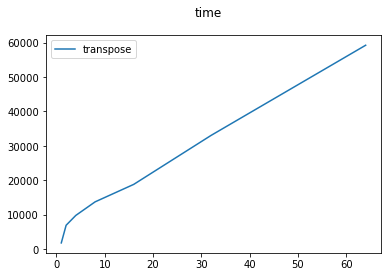

In [8]:
def extract_times(algo, key):
    res = []
    for r in sorted(results, key=lambda r: r['threads']):
        if r['algo'] != algo:
            continue
        res.append((r['threads'], r[key]))
    return res

def plot(key):
    plt.suptitle(key)
    for algo in ['transpose']:
        times = extract_times(algo, key)
        plt.plot([t for t, _ in times], [time for _, time in times], label=algo)
    plt.legend()
    plt.show()

plot('time')

### Solution 7a):
For transposing the csr_matrix type, one just has to simply count the number of elements in each column, produce the corresponding indice vector for the new matrix and then fill the elements in.
This is not as easy to parallize as it seems to be. One can parallize over each row of the old matrix, because all the elements should have different columns, thus preventing race conditions. For bigger matrices one would expect this to scale well, but it doesn't, as seen in the first figure. Instead it scales linear with the number of threads. The reason for that is, that the workload to be parallized, a single row in a sparse matrix, is too small. Therefore the overhead dominates the actual time to transpose the matrix. 

### Solution 7b,c):
The dijkstra implementation takes on average 4192ms for the cit-patent graph and 240ms for the roadNet-TX graph for a sample size of 1000. In our test implementation, the original csr_matrix and the transposed csr_matrix are provided. Thus for a realistic time estimate one would have to add the time for reading the graph and transposing the matrix. As shown in figure 1, the transposition of the cit-patent matrix also takes around 4000ms and therefore shouldn't be ignored.